Mounted at /content/drive
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0884 - val_loss: 0.0053
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0

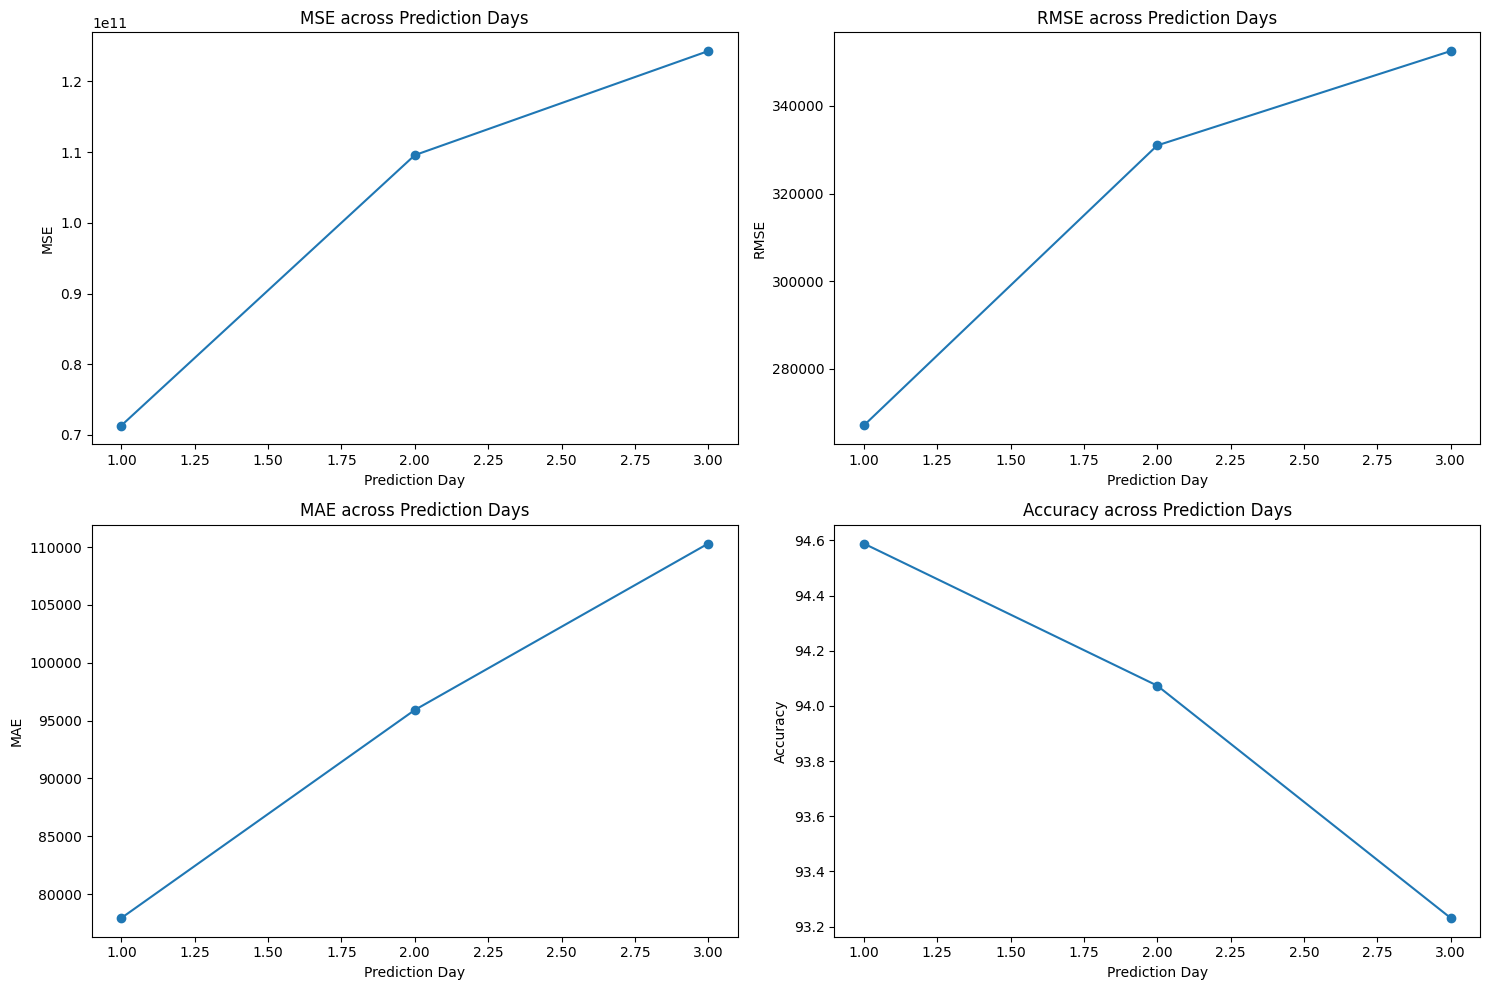

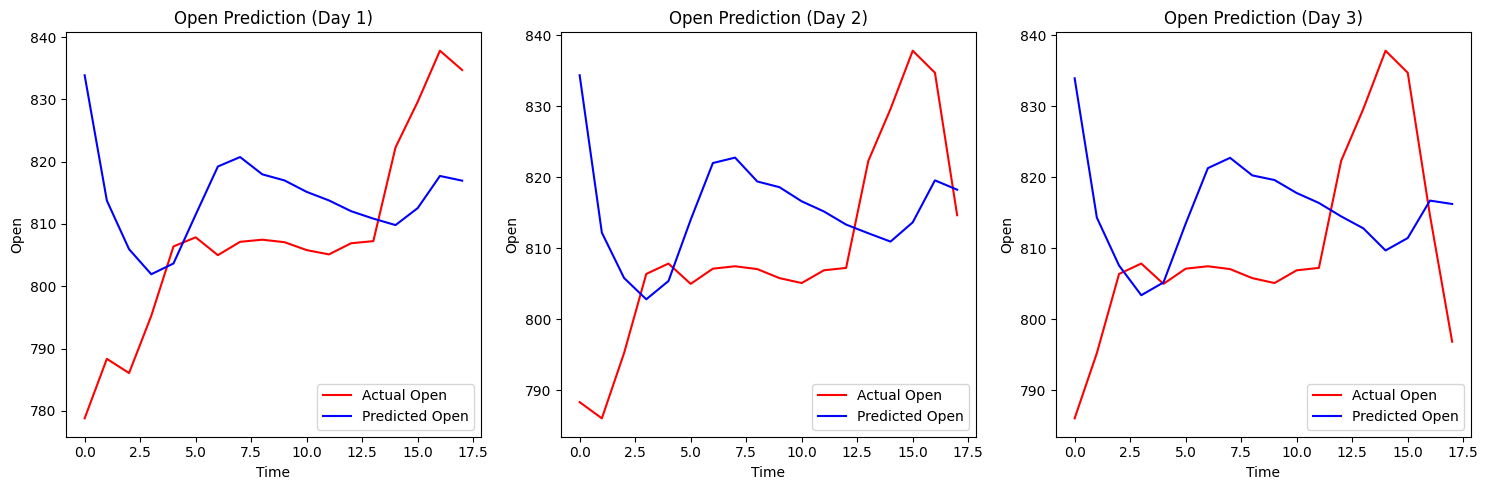

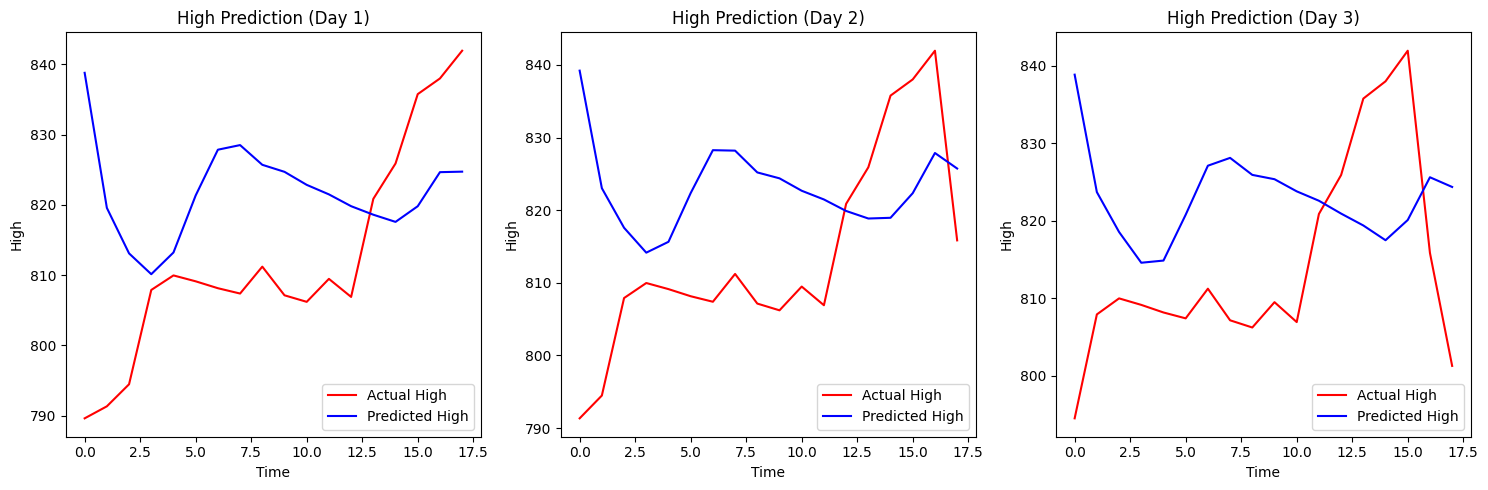

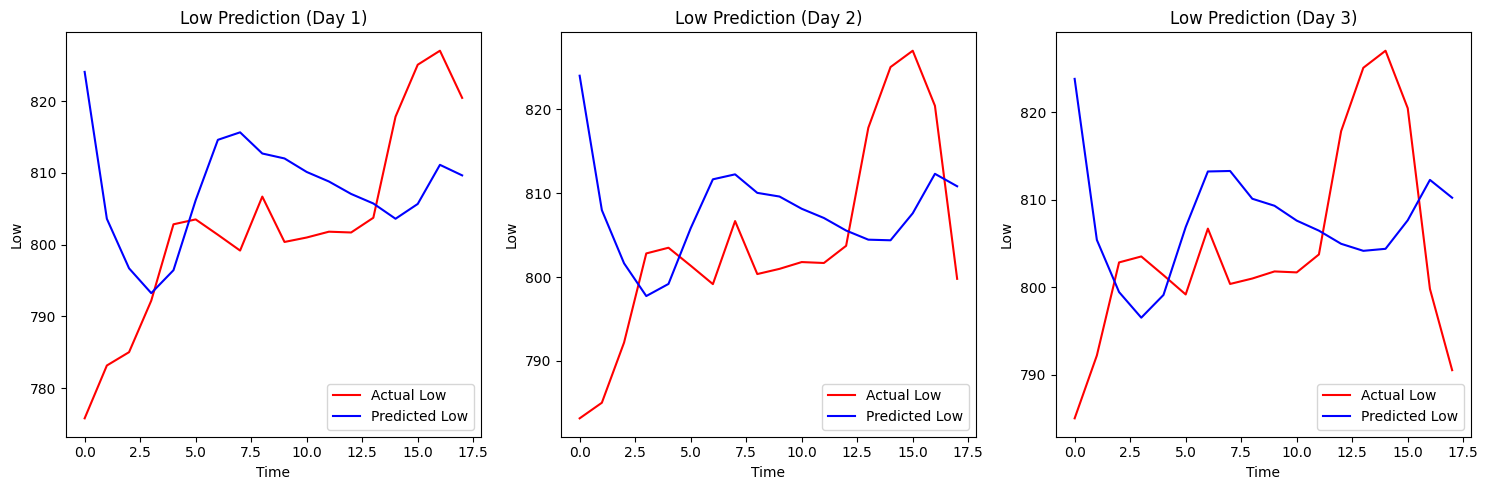

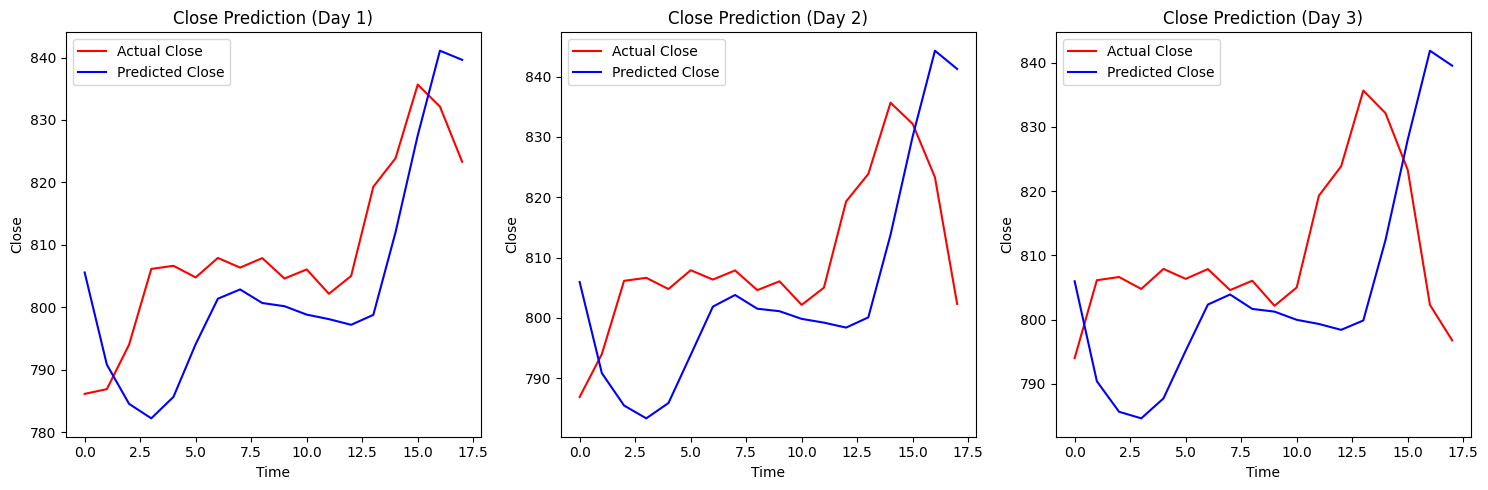

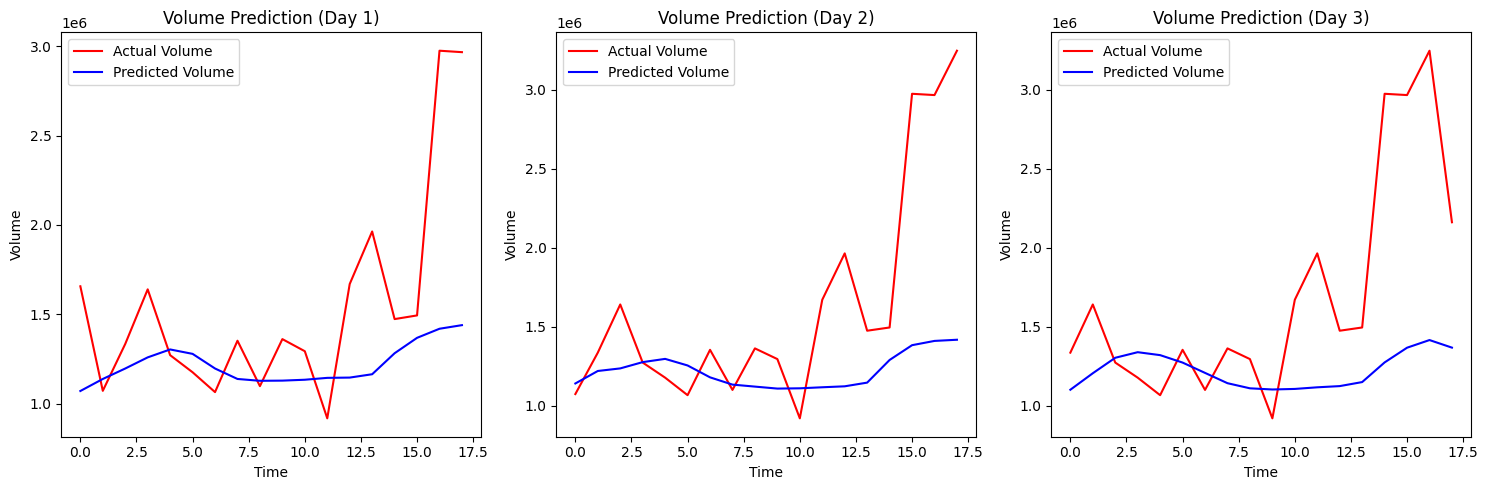

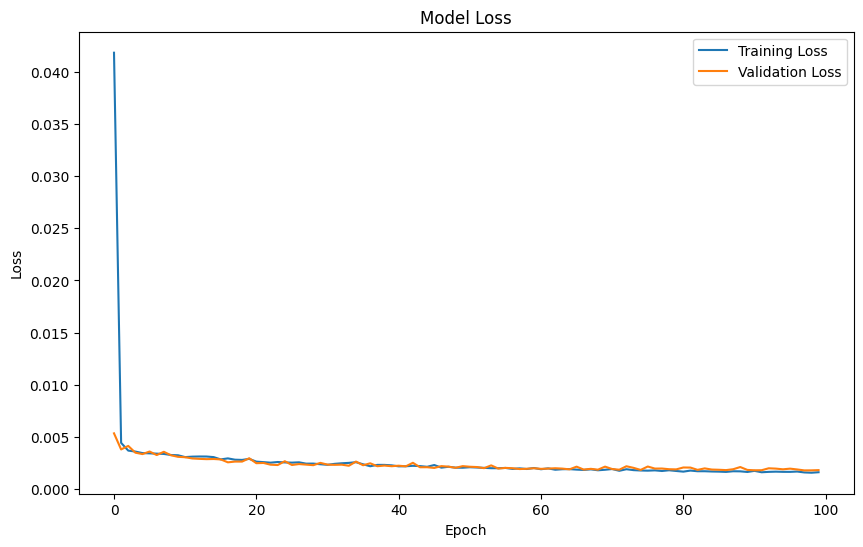

In [5]:
# Sliding Window LSTM

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

def load_and_preprocess_data_multi_feature(file_path):
   data = pd.read_csv(file_path)
   data = data.iloc[:, 1:]
   data = data.replace({',': ''}, regex=True).astype(float)
   scaler = MinMaxScaler(feature_range=(0, 1))
   scaled_data = scaler.fit_transform(data)
   return scaled_data, scaler

def create_sequences(data, seq_length, pred_length):
   X, y = [], []
   for i in range(len(data) - seq_length - pred_length + 1):
       X.append(data[i:(i + seq_length)])
       y.append(data[(i + seq_length):(i + seq_length + pred_length)])
   return np.array(X), np.array(y)

# Model parameters
N = 15
M = 3

train_file = '/content/drive/MyDrive/Google_Stock_Price_Train.csv'
test_file = '/content/drive/MyDrive/Google_Stock_Price_Test.csv'

# Data preparation
train_data, scaler_train = load_and_preprocess_data_multi_feature(train_file)
test_data, scaler_test = load_and_preprocess_data_multi_feature(test_file)

X, y = create_sequences(train_data, N, M)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def prepare_test_data(train_data, test_data, seq_length, pred_length):
   last_train_data = train_data[-seq_length:]
   combined_data = np.vstack((last_train_data, test_data))
   X_test, y_test = create_sequences(combined_data, seq_length, pred_length)
   return X_test, y_test

X_test, y_test = prepare_test_data(train_data, test_data, N, M)

# Enhanced LSTM model
model = Sequential([
   LSTM(100, return_sequences=True, input_shape=(N, train_data.shape[1])),
   Dropout(0.2),
   LSTM(100, return_sequences=True),
   Dropout(0.2),
   LSTM(50),
   Dense(M * train_data.shape[1])
])

optimizer = Adam(learning_rate=0.001, decay=0.001/100)
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(
   X_train, y_train.reshape(y_train.shape[0], -1),
   epochs=100,
   batch_size=32,
   validation_data=(X_val, y_val.reshape(y_val.shape[0], -1))
)

predicted = model.predict(X_test)
predicted = predicted.reshape(-1, M, train_data.shape[1])
predicted_stock_price = np.array([scaler_test.inverse_transform(pred) for pred in predicted])

y_test_reshaped = y_test.reshape(-1, M, train_data.shape[1])
real_stock_price = np.array([scaler_test.inverse_transform(real) for real in y_test_reshaped])

def calculate_metrics(real, pred):
   mse = np.mean((real - pred) ** 2)
   rmse = np.sqrt(mse)
   mae = np.mean(np.abs(real - pred))
   accuracy = 100 - np.mean(np.abs((real - pred) / real)) * 100
   return mse, rmse, mae, accuracy

for day in range(M):
   print(f"\nMetrics for Day {day+1} prediction:")
   mse, rmse, mae, acc = calculate_metrics(real_stock_price[:, day], predicted_stock_price[:, day])
   print(f"MSE: {mse:.2f}")
   print(f"RMSE: {rmse:.2f}")
   print(f"MAE: {mae:.2f}")
   print(f"Accuracy: {acc:.2f}%")

features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(15, 10))
metrics = ['MSE', 'RMSE', 'MAE', 'Accuracy']
for i, metric in enumerate(metrics, 1):
   plt.subplot(2, 2, i)
   metric_values = []
   for day in range(M):
       mse, rmse, mae, acc = calculate_metrics(real_stock_price[:, day], predicted_stock_price[:, day])
       metric_values.append(eval(metric.lower()) if metric != 'Accuracy' else acc)
   plt.plot(range(1, M+1), metric_values, marker='o')
   plt.title(f'{metric} across Prediction Days')
   plt.xlabel('Prediction Day')
   plt.ylabel(metric)
plt.tight_layout()
plt.show()

for i in range(5):
   plt.figure(figsize=(15, 5))
   for day in range(M):
       plt.subplot(1, M, day+1)
       plt.plot(real_stock_price[:, day, i], color='red', label=f'Actual {features[i]}')
       plt.plot(predicted_stock_price[:, day, i], color='blue', label=f'Predicted {features[i]}')
       plt.title(f'{features[i]} Prediction (Day {day+1})')
       plt.xlabel('Time')
       plt.ylabel(features[i])
       plt.legend()
   plt.tight_layout()
   plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Mounted at /content/drive
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1917 - val_loss: 0.1066
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - val_loss: 0.0233
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.0169
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0126
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0089
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0013

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
MSE: 66855409210.04
RMSE: 258564.13
MAE: 78155.73
Accuracy: 95.27%


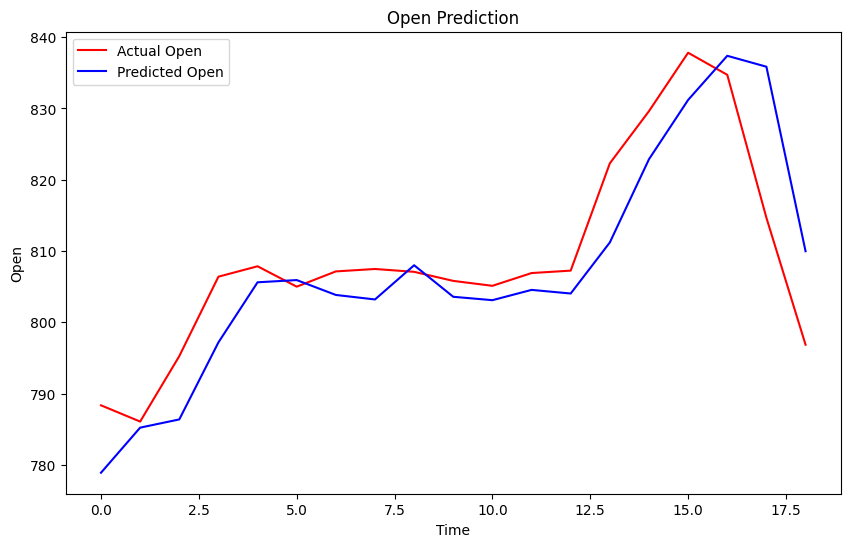

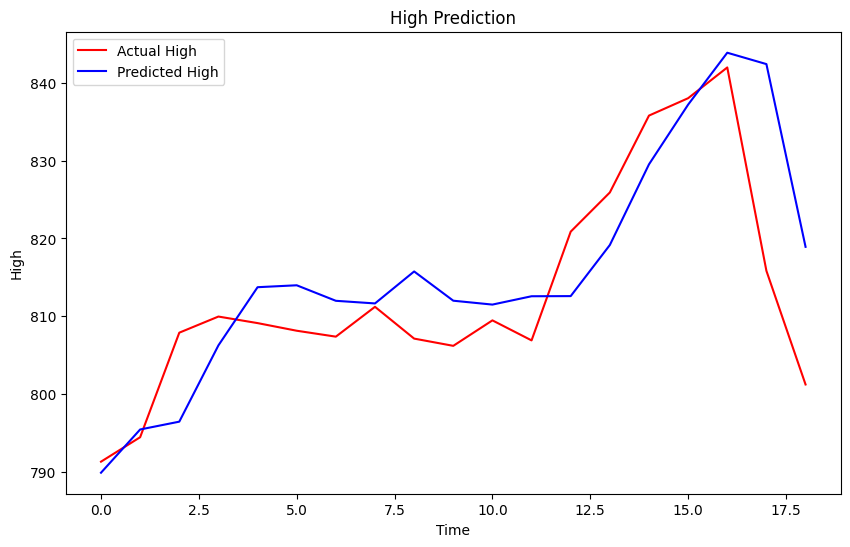

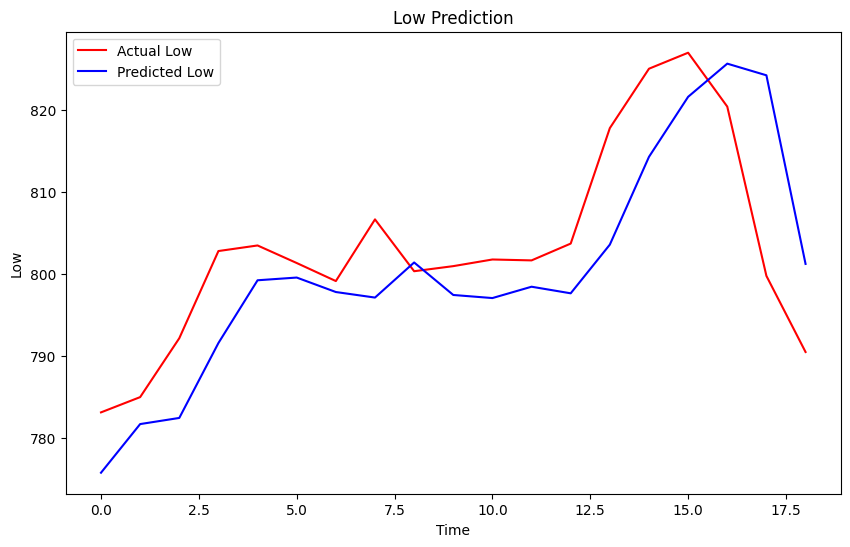

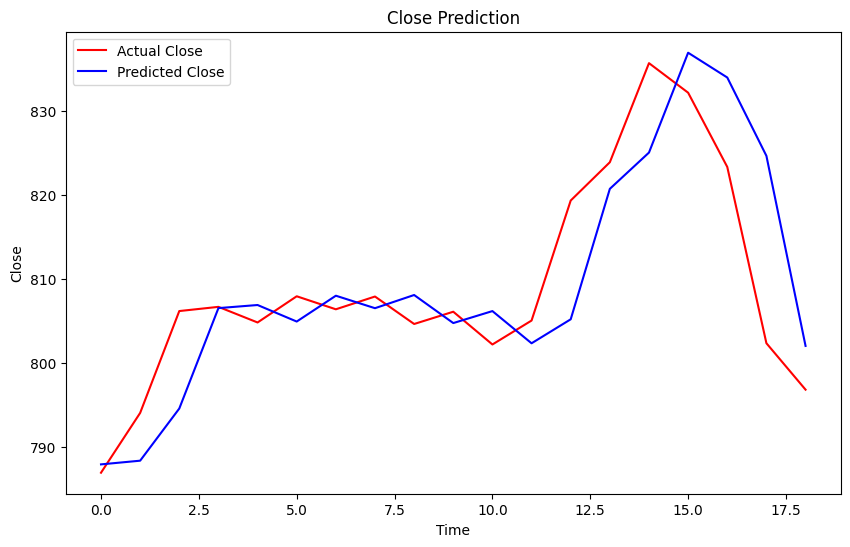

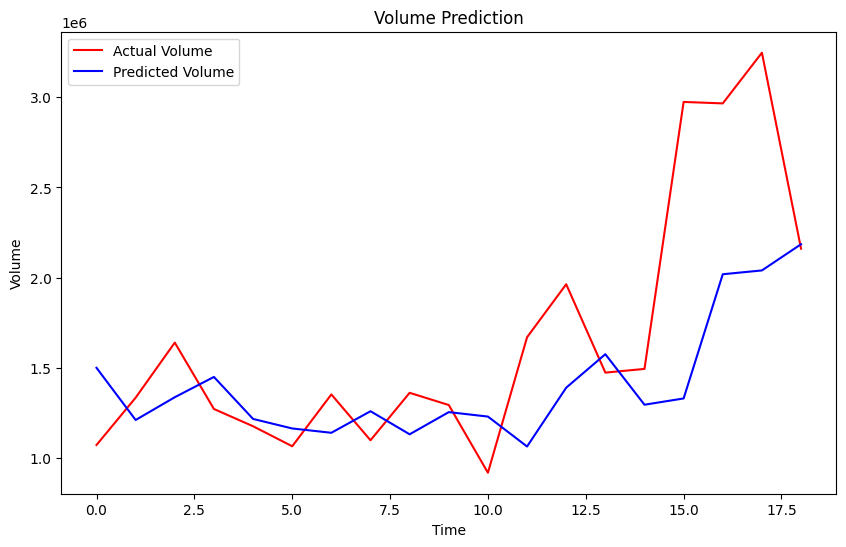

In [10]:
#Windowless LSTM

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def load_and_preprocess_data_multi_feature(file_path):

    data = pd.read_csv(file_path)
    data = data.iloc[:, 1:]
    data = data.replace({',': ''}, regex=True).astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

train_file = '/content/drive/MyDrive/Google_Stock_Price_Train.csv'
test_file = '/content/drive/MyDrive/Google_Stock_Price_Test.csv'

train_data, scaler_train = load_and_preprocess_data_multi_feature(train_file)
test_data, scaler_test = load_and_preprocess_data_multi_feature(test_file)

X = train_data[:-1]
y = train_data[1:]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(test_data[:-1], (test_data.shape[0] - 1, 1, test_data.shape[1]))
y_test = test_data[1:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=5))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_test.inverse_transform(predicted_stock_price)
real_stock_price = scaler_test.inverse_transform(y_test)

mse = np.mean((real_stock_price - predicted_stock_price) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(real_stock_price - predicted_stock_price))
accuracy = 100 - np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

features = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in range(5):
    plt.figure(figsize=(10, 6))
    plt.plot(real_stock_price[:, i], color='red', label=f'Actual {features[i]}')
    plt.plot(predicted_stock_price[:, i], color='blue', label=f'Predicted {features[i]}')
    plt.title(f'{features[i]} Prediction')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.legend()
    plt.show()



Mounted at /content/drive
MSE: 409.00
RMSE: 20.22
MAE: 15.61
Accuracy: 98.09%


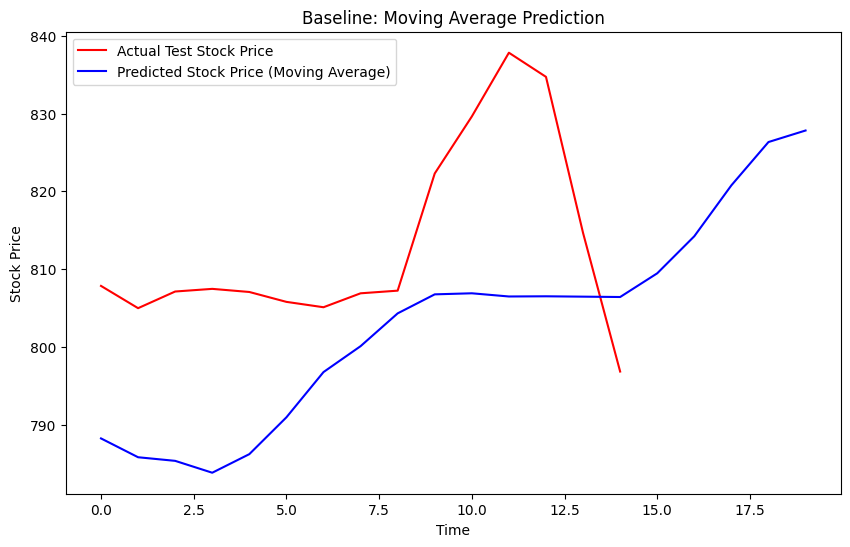

In [1]:
# baseline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_and_preprocess_data_baseline(file_path):
    data = pd.read_csv(file_path)
    data = data.iloc[:, 1:2].values
    return data

train_file = '/content/drive/MyDrive/Google_Stock_Price_Train.csv'
test_file = '/content/drive/MyDrive/Google_Stock_Price_Test.csv'

train_data = load_and_preprocess_data_baseline(train_file)
test_data = load_and_preprocess_data_baseline(test_file)

def moving_average(data, window_size):
    predictions = []
    for i in range(len(data) - window_size):
        predictions.append(np.mean(data[i:i + window_size]))
    return np.array(predictions)

# Set parameters
N = 5

train_predictions = moving_average(train_data, N)

combined_data = np.concatenate((train_data[-N:], test_data))
test_predictions = moving_average(combined_data, N)

actual_test_data = test_data[N:]

def calculate_metrics(real, pred):
    mse = np.mean((real - pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(real - pred))
    accuracy = 100 - np.mean(np.abs((real - pred) / real)) * 100
    return mse, rmse, mae, accuracy

mse, rmse, mae, accuracy = calculate_metrics(actual_test_data, test_predictions)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(actual_test_data, color='red', label='Actual Test Stock Price')
plt.plot(test_predictions, color='blue', label='Predicted Stock Price (Moving Average)')
plt.title('Baseline: Moving Average Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
